<a href="https://colab.research.google.com/github/DRA-chaos/TensorFlow-Quantum-ML/blob/main/MNIST_TensorflowQ_Checkpoint2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 29.8MB/s 
     |████████████████████████████████| 2.9MB 34.5MB/s 
     |████████████████████████████████| 471kB 29.3MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [3]:
!pip install tensorflow-quantum

     |████████████████████████████████| 7.8MB 185kB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
     |████████████████████████████████| 1.3MB 40.2MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 5.6MB 17.9MB/s 
     |████████████████████████████████| 1.5MB 41.1MB/s 
     |████████████████████████████████| 389kB 46.7MB/s 
  Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1
  Found existing installation: google-auth 1.31.0
    Uninstalling google-auth-1.31.0:
      Successfully uninstalled google-auth-1.31.0
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: googleapis-common-protos 1.53.0
    Uninstalling googleapis-common-protos-1.53.0:
      Successfully uninstalled googleapis-common-protos-1.53.0


In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Loading raw MNIST data


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescaling images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  #Normalization

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


We filter the dataset to first classify / recognize only 2 and 4. We make the label y into a boolean variable, true for 2 and false for 4


In [3]:
def filter_24(x, y):
    keep = (y == 2) | (y == 4)
    x, y = x[keep], y[keep]
    y = y == 2
    return x,y

In [4]:
x_train, y_train = filter_24(x_train, y_train)
x_test, y_test = filter_24(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11800
Number of filtered test examples: 2014


False


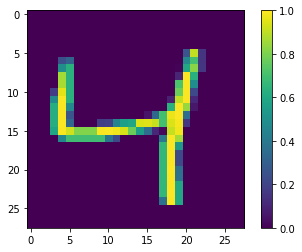

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

Downscaling Image

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

False


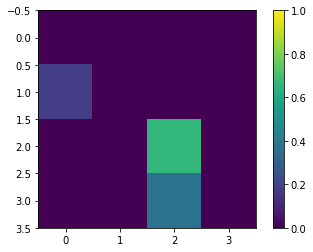

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_2 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_2)
    print("Number of unique 6s: ", num_uniq_4)
    print("Number of unique contradicting labels (both 2 and 4): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10542
Number of unique 3s:  5086
Number of unique 6s:  5323
Number of unique contradicting labels (both 2 and 4):  133

Initial number of images:  11800
Remaining non-contradicting unique images:  10409


In [10]:
#binary encoding
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [12]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 172
Number of unique 3s:  64
Number of unique 6s:  29
Number of unique contradicting labels (both 2 and 4):  79

Initial number of images:  10409
Remaining non-contradicting unique images:  93


In [13]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


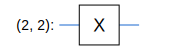

In [14]:
SVGCircuit(x_train_circ[0])

In [15]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2]])

In [16]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

Quantum Neural Network
Building the model circuit (here using 2 qubit gates)

In [17]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

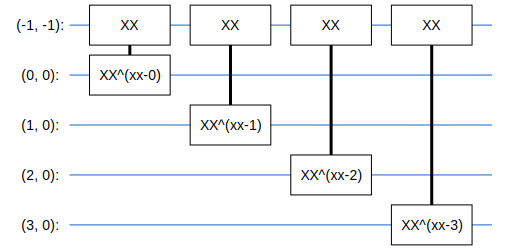

In [18]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [19]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [20]:
model_circuit, model_readout = create_quantum_model()

In [22]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [23]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [24]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [25]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


Training the Quantum Model

In [27]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [28]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [33]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
248/326 [=====================>........] - ETA: 2:45 - loss: 0.9693 - hinge_accuracy: 0.5467

KeyboardInterrupt: ignored

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:50]
y_train_hinge_sub = y_train_hinge[:50]

In [30]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
2/2 [==============================] - 30s 27s/step - loss: 0.9923 - hinge_accuracy: 0.5394 - val_loss: 0.9847 - val_hinge_accuracy: 0.6743
Epoch 2/3
2/2 [==============================] - 29s 26s/step - loss: 0.9880 - hinge_accuracy: 0.5486 - val_loss: 0.9845 - val_hinge_accuracy: 0.6737
Epoch 3/3
63/63 [==============================] - 26s 410ms/step - loss: 0.9845 - hinge_accuracy: 0.6817


In [31]:
x_train_tfcirc_sub = x_train_tfcirc[:75]
y_train_hinge_sub = y_train_hinge[:75]

In [32]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
3/3 [==============================] - 31s 14s/step - loss: 0.9881 - hinge_accuracy: 0.5777 - val_loss: 0.9844 - val_hinge_accuracy: 0.6817
Epoch 2/3
3/3 [==============================] - 31s 14s/step - loss: 0.9867 - hinge_accuracy: 0.6174 - val_loss: 0.9841 - val_hinge_accuracy: 0.6817
Epoch 3/3
63/63 [==============================] - 26s 412ms/step - loss: 0.9837 - hinge_accuracy: 0.6727


In [34]:
x_train_tfcirc_sub = x_train_tfcirc[:20]
y_train_hinge_sub = y_train_hinge[:20]

In [35]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
1/1 [==============================] - 27s 27s/step - loss: 0.9854 - hinge_accuracy: 0.5500 - val_loss: 0.9835 - val_hinge_accuracy: 0.6563
Epoch 2/3
1/1 [==============================] - 27s 27s/step - loss: 0.9850 - hinge_accuracy: 0.5500 - val_loss: 0.9834 - val_hinge_accuracy: 0.6563
Epoch 3/3
63/63 [==============================] - 26s 412ms/step - loss: 0.9832 - hinge_accuracy: 0.6638


In [36]:
NUM_EXAMPLES

10409

In [37]:
x_train_tfcirc_sub = x_train_tfcirc[:100]
y_train_hinge_sub = y_train_hinge[:100]

In [38]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
4/4 [==============================] - 32s 10s/step - loss: 0.9819 - hinge_accuracy: 0.6641 - val_loss: 0.9821 - val_hinge_accuracy: 0.6275
Epoch 2/3
4/4 [==============================] - 32s 10s/step - loss: 0.9803 - hinge_accuracy: 0.5703 - val_loss: 0.9803 - val_hinge_accuracy: 0.6469
Epoch 3/3
63/63 [==============================] - 26s 413ms/step - loss: 0.9787 - hinge_accuracy: 0.6380


In [39]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES-10000]  #considering 409 as number of examples
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES-10000]

In [40]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
13/13 [==============================] - 54s 4s/step - loss: 0.9764 - hinge_accuracy: 0.6784 - val_loss: 0.9674 - val_hinge_accuracy: 0.6713
Epoch 2/3
13/13 [==============================] - 54s 4s/step - loss: 0.9619 - hinge_accuracy: 0.6804 - val_loss: 0.9563 - val_hinge_accuracy: 0.6827
Epoch 3/3
63/63 [==============================] - 26s 413ms/step - loss: 0.9415 - hinge_accuracy: 0.6843


In [44]:
x_train_tfcirc_sub = x_train_tfcirc[:500]  #considering 500 as number of examples
y_train_hinge_sub = y_train_hinge[:500]

In [45]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 61s 4s/step - loss: 0.9288 - hinge_accuracy: 0.6879 - val_loss: 0.9166 - val_hinge_accuracy: 0.6788
Epoch 2/3
16/16 [==============================] - 61s 4s/step - loss: 0.9018 - hinge_accuracy: 0.6824 - val_loss: 0.8878 - val_hinge_accuracy: 0.6768
Epoch 3/3
63/63 [==============================] - 26s 414ms/step - loss: 0.8520 - hinge_accuracy: 0.6931


In [46]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[hinge_accuracy])

In [47]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
x_train_tfcirc_sub = x_train_tfcirc[:500]  #considering 500 as number of examples
y_train_hinge_sub = y_train_hinge[:500]

In [49]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 61s 4s/step - loss: 0.8288 - hinge_accuracy: 0.6912 - val_loss: 0.7912 - val_hinge_accuracy: 0.6981
Epoch 2/3
16/16 [==============================] - 61s 4s/step - loss: 0.7514 - hinge_accuracy: 0.7108 - val_loss: 0.7219 - val_hinge_accuracy: 0.6981
Epoch 3/3
63/63 [==============================] - 26s 414ms/step - loss: 0.6744 - hinge_accuracy: 0.6981
